<a href="https://colab.research.google.com/github/mabugamm/Color-Identification-using-Machine-Learning/blob/master/CV_filnal_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMPUTER VISION - FINAL PROJECT

This is the project of computed vision of  Mohamed Abugammar, Serhat Erdogan, Antoine Gennart and Lander Meeuws.

You can run this notebook from start to end without bugs. In order to reduce exectution time, you can decide to load weights from a trained file. To do so, please include the weights file in the folder "/content/".


In [ ]:
import os
import pandas as pd 
import numpy as np
import skimage
from skimage import io
import skimage.transform as trans
import cv2
from google.colab.patches import cv2_imshow
import string
import random
random.seed(42)
import xml.etree.ElementTree as ET
import tensorflow as tf 
from tensorflow import keras
import re
import PIL
from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras import backend, optimizers
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

## 0. Getting started

### Download the data


In [ ]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals

voc_root_folder = "/content/VOCdevkit/VOC2009"

File ‘VOCtrainval_11-May-2009.tar’ already there; not retrieving.

Total bytes read: 935536640 (893MiB, 226MiB/s)


### Separate the data into train, validation and test sets.

The VOC 2009 dataset that we download contains a training set and a validation set. The test set can be downloaded aside. As it was mentionned in Toledo, assessing the performances of our models on the validation set is sufficient for this work, therefore, we do not download the test set.


In [ ]:
# from <https://github.com/mprat/pascal-voc-python/blob/master/voc_utils/voc_utils.py>
img_dir = os.path.join(voc_root_folder, 'JPEGImages/')
ann_dir = os.path.join(voc_root_folder, 'Annotations')
set_dir = os.path.join(voc_root_folder, 'ImageSets', 'Main')
seg_dir = os.path.join(voc_root_folder, 'SegmentationClass')

def list_image_sets():
    """
    List all the image sets from Pascal VOC. Don't bother computing
    this on the fly, just remember it. It's faster.
    """

    return [
        'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train',
        'tvmonitor']

def get_class_index(Class):
    return list_image_sets().index(Class)

The two function below are made to load all the informations relative to the data inside a dataframe. The images are not directly loaded, only a reference path to images is stored. During training and testing, these data would be dynamically loaded using a keras object ImageDataGenerator.

In [ ]:
def get_class_data(raw_data_row):
    ''' 
    return a list of string corresponding to the labels of the row
    '''
    my_class = []
    for label in list_image_sets():
        if raw_data_row[label] == 1:
            my_class.append(label)
    return my_class

def create_class_set(suffix="_train.txt"):
    '''
    Create a dataset of multiple feature image in a DataFrame
    '''

    df_list = []
    count_class = {}

    for class_label in list_image_sets():
        filename = os.path.join(set_dir, class_label+suffix)
        df = pd.read_csv(filename, delimiter='\s+', header=None)
        df.columns = ["img_name", class_label]

        df_list.append(df)
        count_class[class_label] = df.loc[df[class_label]==1].shape[0]

    # Create dataframe of raw image
    raw_data = df_list[0]
    for df in df_list[1:]:
        raw_data = raw_data.merge(df, on="img_name")
    raw_data['classes'] = raw_data.apply(lambda x : get_class_data(x), axis=1)
    raw_data['seg_name'] = raw_data['img_name'].apply(lambda x : x+".png")
    raw_data['img_name'] = raw_data['img_name'].apply(lambda x : x+".jpg")
    raw_data['seg_exists'] = raw_data['seg_name'].apply(lambda x: os.path.exists(os.path.join(seg_dir, x)))
    
    print(count_class)

    # Cleaning and removing useless column
    data_classification = raw_data.copy()
    for label in list_image_sets():
        del data_classification[label]

    data_seg = data_classification.loc[data_classification['seg_exists']==True]

    print(len(data_seg))
    return data_classification, data_seg, raw_data

### Create dataframe containing the data for classification and segmentation.

Using the two functions described below, two kind of dataset are built: training and validation set. As classification and segmentation does not require the same input data, different dataframes are used for these two kind of networks.

The object named ```raw_data``` is not used for training nor for testing. It is only used to display some examples images (see next cell).

In [ ]:
train_data_class, train_data_seg, raw_data = create_class_set(suffix="_train.txt")
valid_data_class, valid_data_seg, _ = create_class_set(suffix="_val.txt")


{'aeroplane': 201, 'bicycle': 167, 'bird': 262, 'boat': 170, 'bottle': 220, 'bus': 132, 'car': 372, 'cat': 266, 'chair': 338, 'cow': 86, 'diningtable': 140, 'dog': 316, 'horse': 161, 'motorbike': 171, 'person': 1333, 'pottedplant': 166, 'sheep': 67, 'sofa': 155, 'train': 164, 'tvmonitor': 180}
436
{'aeroplane': 206, 'bicycle': 181, 'bird': 243, 'boat': 155, 'bottle': 200, 'bus': 126, 'car': 358, 'cat': 277, 'chair': 330, 'cow': 86, 'diningtable': 131, 'dog': 333, 'horse': 167, 'motorbike': 167, 'person': 1446, 'pottedplant': 166, 'sheep': 64, 'sofa': 153, 'train': 160, 'tvmonitor': 173}
423


### Show random images from the training set 

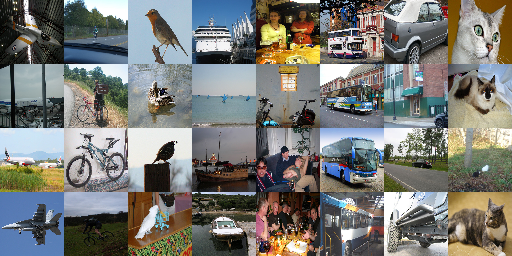

In [ ]:
Num_img_per_class = 4

himage = None
for class_label in list_image_sets()[:8]:
    img_name_ = raw_data["img_name"].loc[raw_data[class_label]==1]
    vimage = None
    for img_name in random.sample(tuple(img_name_), Num_img_per_class):
        img = cv2.imread(os.path.join(img_dir, img_name))
        img = cv2.resize(img, (64, 64))
        if vimage is None:
            vimage = img
        else:
            vimage = cv2.vconcat([vimage, img])

    if himage is None:
        himage = vimage
    else:
        himage = cv2.hconcat([himage, vimage])

cv2_imshow(himage)

           img_name      classes         seg_name  seg_exists
1   2008_000015.jpg     [bottle]  2008_000015.png        True
2   2008_000019.jpg        [dog]  2008_000019.png        True
5   2008_000033.jpg  [aeroplane]  2008_000033.png        True
14  2008_000074.jpg        [car]  2008_000074.png        True
16  2008_000089.jpg      [chair]  2008_000089.png        True


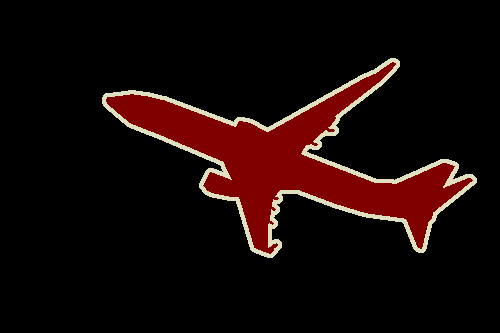

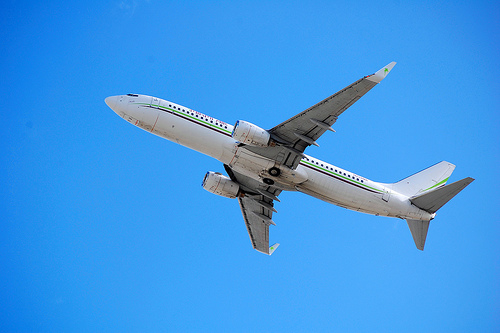

In [ ]:
print(train_data_seg.head())
name = "2008_000033"
seg_name = name + ".png"
img_name = name + ".jpg"
seg_path = os.path.join(seg_dir,seg_name)
img_path = os.path.join(img_dir, img_name)

seg = cv2.imread(seg_path)
cv2_imshow(seg)
img = cv2.imread(img_path)
cv2_imshow(img)

## Task 1: Classification



### From scratch

#### Build data generator

---

First, we create an ImageDataGenerator to dynamically load the images during training. Furthermore, it automatically manage to perform data augmentation and pre-process the inputs to increase the performance of the network.

Here the only pre-processing done is a rescaling of the image. Initially, it is an array of numbers between 0 and 255, after this step it is an array of floating point numbers between 0 and 1.

The input shape of the CNN from scratch can be chosen and is ```CNN_input_shape_scratch = (128, 128, 3)```

In [ ]:
# Dynamically load the images
datagen_scratch=ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

CNN_input_shape_scratch = np.array((128, 128, 3))
batch_size_scratch = 32

# Train generator
train_it_scratch = datagen_scratch.flow_from_dataframe(
    dataframe=train_data_class,
    directory=img_dir,
    x_col="img_name",
    y_col="classes",
    subset="training",
    batch_size=batch_size_scratch,
    seed=42,
    shuffle=True,
    target_size=CNN_input_shape_scratch[:2],
    class_mode="categorical"
)

# Dynamically load the images
datagen_scratch_valid=ImageDataGenerator()

# Valid generator
valid_it_scratch = datagen_scratch_valid.flow_from_dataframe(
    dataframe=valid_data_class,
    directory=img_dir,
    x_col="img_name",
    y_col="classes",
    batch_size=batch_size_scratch,
    seed=42,
    shuffle=True,
    target_size=CNN_input_shape_scratch[:2],
    class_mode="categorical"
)

STEP_SIZE_TRAIN_SCRATCH=train_it_scratch.n//train_it_scratch.batch_size
STEP_SIZE_VALID_SCRATCH=valid_it_scratch.n//valid_it_scratch.batch_size

Found 3473 validated image filenames belonging to 20 classes.
Found 3581 validated image filenames belonging to 20 classes.


#### Implement model

---

The first layer of this network is a pre-processing function. This pre-processing function transform the input images range of numbers from [0 255] to [-1 1].

The next layers consist of a set of convolutional layers and max pooling layers. The function of these layers is to extract features from the image.

The last two layers are fully connected layers to perform the actual classification. The activation function of the last layer is a ```softmax``` activation function. This activation function transform a vector of output into a vector of probabilities (the sum of all the that inside the output vector is equal to 1).

The predicted label is then the label for which the probability is the highest.

In [ ]:

def model_classifier(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Classifire
    conv1 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    flatt1 = Flatten()(pool3)
    dense1 = Dense(512, activation = ('relu'))(flatt1)
    dense2 = Dense(20, activation = ('relu'), kernel_regularizer='l1')(dense1)

    model_scratch = Model(input = inputs, output = dense2)

    model_scratch.compile(loss='categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy', tf.keras.metrics.Precision(name="precision")])

    model_scratch.name = "from_scratch" # Do not change this name
    model_scratch.summary()
    return model_scratch


In [ ]:
NO_OF_TRAINING_IMAGES = len(train_data_class)
NO_OF_EPOCHS = 50
BATCH_SIZE = 32
INPUT_SIZE = (128, 128, 3)

# This path will be used to save the weights after training
weights_path_scratch = './content/weights_scratch'

# Define our model
model_scratch = model_classifier(input_shape=INPUT_SIZE)

checkpoint = ModelCheckpoint(weights_path_scratch, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
earlystopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

# Callbacks list is used to check during training different parameters. For example, earlystopping will stop the training process when, after 8 itterations, the val_dice_coef is still not imporved.
callbacks_list = [checkpoint, earlystopping]

Model: "from_scratch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


#### Train model

---

The final set is to train the model (or load it from a weight file). We choose to train our model during 10 epochs since the accuracy of the model stops inscreasing.

In [ ]:
model_scratch_file = "/content/model_scratch_weights.h5"
history_class = None
if not os.path.isfile(model_scratch_file):
    history_class = model_scratch.fit_generator(generator=train_it_scratch,
                        steps_per_epoch=STEP_SIZE_TRAIN_SCRATCH,
                        validation_data=valid_it_scratch,
                        validation_steps=STEP_SIZE_VALID_SCRATCH,
                        epochs=10)
    model_scratch.save_weights(model_scratch_file)
else:
    model_scratch.load_weights(model_scratch_file)

Epoch 1/10
108/108 [==============================] - 46s 426ms/step - loss: 17.3930 - accuracy: 0.0796 - precision: 0.0597 - val_loss: 14.3711 - val_accuracy: 0.0760 - val_precision: 0.0577
Epoch 2/10
108/108 [==============================] - 43s 395ms/step - loss: 16.0612 - accuracy: 0.0820 - precision: 0.0573 - val_loss: 13.2786 - val_accuracy: 0.0811 - val_precision: 0.0572
Epoch 3/10
108/108 [==============================] - 43s 395ms/step - loss: 13.2634 - accuracy: 0.0939 - precision: 0.0576 - val_loss: 9.9099 - val_accuracy: 0.1792 - val_precision: 0.0610
Epoch 4/10
108/108 [==============================] - 42s 391ms/step - loss: 8.8827 - accuracy: 0.1584 - precision: 0.0638 - val_loss: 7.4189 - val_accuracy: 0.1789 - val_precision: 0.0656
Epoch 5/10
108/108 [==============================] - 42s 391ms/step - loss: 8.0174 - accuracy: 0.1589 - precision: 0.0671 - val_loss: 8.7328 - val_accuracy: 0.1795 - val_precision: 0.0682
Epoch 6/10
108/108 [==============================

#### Show results

---

The history of training is shown in the graphics below (if you trained the network by yourself). This history shows that the performance of the network does not really increase as a function of the time.

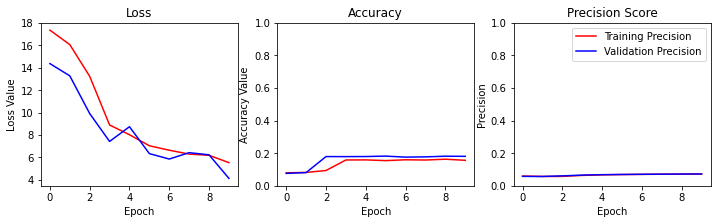

In [ ]:
if history_class is not None:
    loss = history_class.history['loss']
    loss_val = history_class.history['val_loss']
    acc = history_class.history['accuracy']
    acc_val = history_class.history['val_accuracy']
    prec = history_class.history['precision']
    prec_val = history_class.history['val_precision']

    epochs = np.arange(len(history_class.history['loss'])) # This will give the number of itterations that are done during training.

    plt.figure(figsize=(12, 3))
    plt.subplot(131)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.subplot(132)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Value')
    plt.ylim([0, 1])
    plt.subplot(133)
    plt.plot(epochs, prec, 'r', label='Training Precision')
    plt.plot(epochs, prec_val, 'b', label='Validation Precision')
    plt.title('Precision Score')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

### From an existing model

#### Build data generator 

---

As for the model from scratch, a data generator must be built. It must be another data generator since the model resnet50 uses a predefined preprocessing function. In this case, the pre-processing function is embedded inside the data generator (it could have been embedded inside the CNN).

In [ ]:
# from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import preprocess_input

datagen_transfer=ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function = preprocess_input)

CNN_input_shape_transfer = (224, 224, 3)
batch_size_transfer = 32

train_it_transfer = datagen_transfer.flow_from_dataframe(
    dataframe=train_data_class,
    directory=img_dir,
    x_col="img_name",
    y_col="classes",
    subset="training",
    batch_size=batch_size_transfer,
    seed=42,
    shuffle=True,
    target_size=CNN_input_shape_transfer[:2],
    class_mode="categorical"
)

datagen_transfer_valid=ImageDataGenerator(
        preprocessing_function = preprocess_input)

valid_it_transfer = datagen_transfer_valid.flow_from_dataframe(
    dataframe=valid_data_class,
    directory=img_dir,
    x_col="img_name",
    y_col="classes",
    batch_size=batch_size_transfer,
    seed=42,
    shuffle=True,
    target_size=CNN_input_shape_transfer[:2],
    class_mode="categorical"
)

STEP_SIZE_TRAIN_TRANSFER=train_it_transfer.n//train_it_transfer.batch_size
STEP_SIZE_VALID_TRANSFER=valid_it_transfer.n//valid_it_transfer.batch_size


Found 3473 validated image filenames belonging to 20 classes.
Found 3581 validated image filenames belonging to 20 classes.


#### Implement model

---

Keras provides a set of pre-trained model for transfer learning. The list of available models can be found in [keras applications](https://keras.io/api/applications/).

**Networks parameters**

The best network in this set of model is the InceptionResNetV2, that we are using. While loading the model, some parameters must be set:
* ```include_top=False``` which means that we do not include the final classification layer of the network, because we want to add a custom additional layer to fit our dataset. In this case, the last layer of the imported model contains features of the input images that will be used for classification.
* ```weigths='imagenet'``` because we are using pre-trained weights from a model that learned its parameter over _imagenet_ dataset.
* ```input_shape``` is imposed by the network that we are using because the pre-trained model is the input of our system. Therefore, it must be set to (224,224,3).

Most of the trainable parameters of the complete systems are in the pre-trained model. In order to train only the untrained, the layer named ```layer_transfer```, we set the parameter ```trainable``` to False.

##### **Compilation parameters**

The parameters specified in this section describe what are the functions to be used to update the weights while training the network.

* We use the default optimizer : ```Adam()```
* The loss function is ```categorical crossentropy```.

Now is time to implement the transfer learning model

In [ ]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Conv2D, MaxPooling2D, BatchNormalization, Layer, Dropout
from keras import optimizers, backend
top_1_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=1, name="top_1_categorical_accuracy", dtype=None)
top_3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top_3_categorical_accuracy", dtype=None)


transfer_layer = ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_shape=CNN_input_shape_transfer)
transfer_layer.trainable = False

model_transfer = Sequential()
model_transfer.add(transfer_layer)
model_transfer.add(Flatten())
model_transfer.add(Dense(20, activation='softmax'))

model_transfer.compile(
    optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy', tf.keras.metrics.Precision(name="precision")])

model_transfer.name = "transfer_learning"

model_transfer.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step
Model: "transfer_learning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2007060   
Total params: 25,594,772
Trainable params: 2,007,060
Non-trainable params: 23,587,712
_________________________________________________________________


#### Train model

---

In [ ]:
model_transfer_file = "/content/model_transfer_weights.h5"
history_class_transfer = None
if not os.path.isfile(model_transfer_file):
    history_class_transfer = model_transfer.fit_generator(generator=train_it_transfer,
                        steps_per_epoch=STEP_SIZE_TRAIN_TRANSFER,
                        validation_data=valid_it_transfer,
                        validation_steps=STEP_SIZE_VALID_TRANSFER,
                        epochs=10)
    model_transfer.save_weights(model_transfer_file)
else:
    model_transfer.load_weights(model_transfer_file)

Epoch 1/10
108/108 [==============================] - 111s 1s/step - loss: 26.1815 - accuracy: 0.3653 - precision: 0.4300 - val_loss: 19.8300 - val_accuracy: 0.5343 - val_precision: 0.5945
Epoch 2/10
108/108 [==============================] - 103s 953ms/step - loss: 29.7870 - accuracy: 0.4609 - precision: 0.6294 - val_loss: 48.6748 - val_accuracy: 0.5948 - val_precision: 0.6511
Epoch 3/10
108/108 [==============================] - 103s 955ms/step - loss: 36.8120 - accuracy: 0.4789 - precision: 0.6682 - val_loss: 52.1658 - val_accuracy: 0.5556 - val_precision: 0.6736
Epoch 4/10
108/108 [==============================] - 101s 939ms/step - loss: 40.6071 - accuracy: 0.5004 - precision: 0.6796 - val_loss: 63.5621 - val_accuracy: 0.6148 - val_precision: 0.6870
Epoch 5/10
108/108 [==============================] - 101s 932ms/step - loss: 46.0290 - accuracy: 0.5185 - precision: 0.6934 - val_loss: 45.4864 - val_accuracy: 0.5644 - val_precision: 0.6972
Epoch 6/10
108/108 [=======================

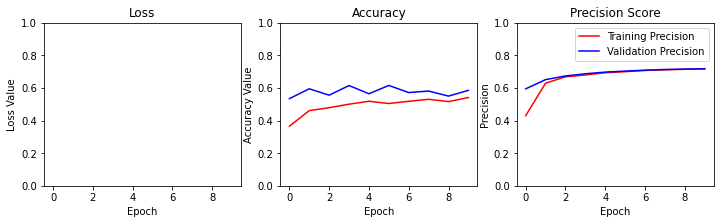

In [ ]:
if history_class_transfer is not None:
    loss = history_class_transfer.history['loss']
    loss_val = history_class_transfer.history['val_loss']
    acc = history_class_transfer.history['accuracy']
    acc_val = history_class_transfer.history['val_accuracy']
    prec = history_class_transfer.history['precision']
    prec_val = history_class_transfer.history['val_precision']

    epochs = np.arange(len(history_class_transfer.history['loss'])) # This will give the number of itterations that are done during training.

    plt.figure(figsize=(12, 3))
    plt.subplot(131)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.subplot(132)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Value')
    plt.ylim([0, 1])
    plt.subplot(133)
    plt.plot(epochs, prec, 'r', label='Training Precision')
    plt.plot(epochs, prec_val, 'b', label='Validation Precision')
    plt.title('Precision Score')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

### Comparison of both models

We can use the evaluation function provided by **Keras**. This function compute the accuracy metric used when we compiled our model: The accuracy and the precision.

* **Accuracy** (as defined by keras) : The number of times the prediction match the expectation divided by the total number of tests. However, there are a lot of cases where we have multiple class for a single image. For these image it is not possible to be correct.

* **Precision** (as defined by keras) : Similar than the accuracy, expect that we are computing a distance from the prediction to the expectation. Therefore it is a better metric than accuracy since the precision increase when there are two labels to be predicted and that our model only predict one.

In [ ]:
# score_scratch, accuracy_scratch, precision_scratch = model_scratch.evaluate_generator(valid_it_scratch, STEP_SIZE_TRAIN_SCRATCH)
score_transfer, accuracy_transfer, precision_transfer = model_transfer.evaluate_generator(valid_it_transfer, STEP_SIZE_TRAIN_TRANSFER)

# print(score_scratch, accuracy_scratch, precision_scratch)
print(score_transfer, accuracy_transfer, precision_transfer)

NameError: ignored

As we have seen previously, **accuracy** and **precision** are not the perfect metric we are looking for. We want a metric which represent the fact that we are able to get at least one correct label for each image. Therefore we have to create it. 

The function below is able to compute the accuracy we are looking for. It consider to be a correct classification it classify the image as one of the class of the image.

In [ ]:
def evaluate_classification(model):
    test_it = None
    if model.name=="transfer_learning":
        test_it = valid_it_transfer
    elif model.name=="from_scratch":
        test_it = valid_it_scratch
    else:
        print("I do not know the model")
        return 0
    
    n_errors = 0
    n_correct = 0

    test_it.batch_size = 1
    for i in range(test_it.n):
        X_test, y_test = next(test_it)
        y_pred = model.predict(X_test)
        idx = 0
        for value in y_pred[0]:
            if value==max(y_pred[0]): # predicted to be class_list[idx]
                if(y_test[0][idx]==1):
                    n_correct = n_correct+1
                else:
                    n_errors = n_errors+1
            idx = idx + 1

    real_accuracy = n_correct / (n_correct + n_errors)
    return real_accuracy

# print("Real accuracy for model from scratch is : ", evaluate_classification(model_scratch))
print("Real accuracy for transfer learning  is : ", evaluate_classification(model_transfer))

Real accuracy for transfer learning  is :  0.7567718514381457


## Task 2: Semantic segmentation

### From scracth

A general semantic segmentation architecture can be broadly thought of as an encoder network followed by a decoder network:

*   **The encoder** is usually a classification network (e.g. ResNet50) followed by a decoder network.

*   The task of **the decoder** is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification.

The model that is used as basis for implementation is the UNET MODEL. This model appears in literature as one of the best models for segmentation tasks.

--

The difference between a classification architecture and sementic segmentation architecture is that the classification model only excists of an encoder, followed by a dense layer such that a summary of learned input can be made. The segmentation model outputs an exact description where the object is within a frame. In other words, returns the segment where the object is situated. The output of a classifier is a class where the object within the image belongs. The output from a classification model is a global description of WHAT is inside the frame, rather than WHERE it is inside a frame.

In [ ]:
# Create dir to store results
cv_folder = '/content/segmentation'
if not os.path.isdir(cv_folder):
  os.mkdir(cv_folder)

print(train_data_seg.head())

# Now we will split images and masks (labels)
train_seg_img = train_data_seg['img_name']
train_seg_mask = train_data_seg['seg_name']

test_seg_img = valid_data_seg['img_name']
test_seg_mask = valid_data_seg['seg_name']

           img_name      classes         seg_name  seg_exists
1   2008_000015.jpg     [bottle]  2008_000015.png        True
2   2008_000019.jpg        [dog]  2008_000019.png        True
5   2008_000033.jpg  [aeroplane]  2008_000033.png        True
14  2008_000074.jpg        [car]  2008_000074.png        True
16  2008_000089.jpg      [chair]  2008_000089.png        True


#### Implement Model (UNET):

---

- The model:

In order to be able to train a segmentation model from scratch, we should first start with defining the architecture from the model. We have chosen for the Unet model. This model occurs many times within the literature and is seen as one of the best, current, models to do segmentation. 

Within this model, skip connections are used. These connections are pointing from the encoder side, to the decoder side and are used to provide the decoder with extra information on pixel level. These layers are the concatenate() layers within the implementation of the model.



- The loss function (Dice Coefficient):

Segmentation models differ from classification models in that classification models outputs labels, where segmentation models outputs images (at least one difference). This means that we should come up with a way to measure the performance of our model. A well know metric is the Dice Coefficient score.

$dice = \dfrac{2 * Intersection}{Union + Intersection}$ = $ \dfrac{2 * TruePositive}{2 * TruePositive + FalseNegative + FalsePositive} $

This means that we get a weighted score based on predicitions (pixels predicted the same in case). This score give a harmonic mean. This means that, compared to the IuO score, we don't have a biased towards the highest value. A problem in metric calculations is the one of linear mean where a score can be biased towards the metric with the highest value. In this case of a harmonic mean, the score will be directing to the lowest value (TP, FP, FN). At the end, we want to maximise the score and hence all values should be good.



In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 0.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# implementation based on: https://github.com/zhixuhao/unet model is adjusted to fit our needs.

def unet(input_size, pretrained_weights = None):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(20, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    # Masks are RGB images, this means that we should be sure that the Unet model can handle RGB values.
    conv10 = Conv2D(3, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)
    model.compile(optimizer = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss=dice_coef_loss, metrics=[dice_coef, "accuracy"])
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


Once our model is implemented, we can define variables and setup a model in order to train it.

In [ ]:
NO_OF_TRAINING_IMAGES = len(train_seg_img)
NO_OF_EPOCHS = 50
BATCH_SIZE = 8
INPUT_SIZE = (256, 256, 3)

# This path will be used to save the weights after training
weights_path_scratch = os.path.join(cv_folder, 'weights_unet_scratch')

# Define our model
model_scratch = unet(input_size=INPUT_SIZE)

checkpoint = ModelCheckpoint(weights_path_scratch, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger('./log.out', append=True, separator=';')
earlystopping = EarlyStopping(monitor = 'val_dice_coef', verbose = 1, min_delta = 0.01, patience = 8, mode='max')

# Callbacks list is used to check during training different parameters. For example, earlystopping will stop the training process when, after 8 itterations, the val_dice_coef is still not imporved.
callbacks_list = [checkpoint, csv_logger, earlystopping]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


#### Build data generator

---

The generators will be used for data augementation and preprocessing. The ImageDataGenerator will do the augementation, while the flow_from_dataframe() part will do the pre-processing. Both masks and images should be preprocessed in the same way. Otherwise, to say it simple, the labels will not be correct anymore. Meaning that the masks and images will not be the same anymore. 

In [ ]:
train_datagen_images = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_datagen_masks = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Creat training images and masks
RESIZE_INPUT = (256, 256)

train_image_generator = train_datagen_images.flow_from_dataframe(
    dataframe=train_data_seg,
    directory=img_dir,
    x_col="img_name",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=RESIZE_INPUT,
    class_mode=None)

train_mask_generator = train_datagen_masks.flow_from_dataframe(
    dataframe=train_data_seg,
    directory=seg_dir,
    x_col="seg_name",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=RESIZE_INPUT,
    class_mode=None)

# Creat training images and masks

validate_image_generator = train_datagen_images.flow_from_dataframe(
    dataframe=train_data_seg,
    directory=img_dir,
    x_col="img_name",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=RESIZE_INPUT,
    class_mode=None)
validate_mask_generator = train_datagen_masks.flow_from_dataframe(
    dataframe=train_data_seg,
    directory=seg_dir,
    x_col="seg_name",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=RESIZE_INPUT,
    class_mode=None)

train_generator_scratch = (pair for pair in zip(train_image_generator, train_mask_generator))
validation_generator_scratch = (pair for pair in zip(validate_image_generator, validate_mask_generator))

Found 349 validated image filenames.
Found 349 validated image filenames.
Found 87 validated image filenames.
Found 87 validated image filenames.


#### Train model

---

Now we are ready to train our model from scratch. If we have already a weight_file, use it! 

In [ ]:
model_scratch_file = '/content/model_scratch_seg.h5'
history_scratch = None
if not os.path.isfile(model_scratch_file):
    history_scratch = model_scratch.fit(train_generator_scratch, 
                        epochs=NO_OF_EPOCHS, 
                        steps_per_epoch = (NO_OF_TRAINING_IMAGES*0.8//BATCH_SIZE), 
                        callbacks=callbacks_list,
                        validation_data = (item for item in validation_generator_scratch), 
                        validation_steps = (NO_OF_TRAINING_IMAGES*0.2//BATCH_SIZE))
    model_scratch.save(model_scratch_file)
else:
    model_scratch.load_weights(model_scratch_file)

Epoch 1/50
43/43 [==============================] - 77s 2s/step - loss: 0.7999 - dice_coef: 0.2001 - accuracy: 0.2896 - val_loss: 0.9141 - val_dice_coef: 0.1891 - val_accuracy: 0.1119

Epoch 00001: val_dice_coef improved from -inf to 0.18915, saving model to /content/segmentation/weights_unet_scratch
Epoch 2/50
43/43 [==============================] - 70s 2s/step - loss: 0.7476 - dice_coef: 0.2524 - accuracy: 0.1396 - val_loss: 0.7648 - val_dice_coef: 0.2775 - val_accuracy: 0.1517

Epoch 00002: val_dice_coef improved from 0.18915 to 0.27748, saving model to /content/segmentation/weights_unet_scratch
Epoch 3/50
43/43 [==============================] - 59s 1s/step - loss: 0.6981 - dice_coef: 0.3019 - accuracy: 0.2118 - val_loss: 0.6625 - val_dice_coef: 0.3012 - val_accuracy: 0.2093

Epoch 00003: val_dice_coef improved from 0.27748 to 0.30118, saving model to /content/segmentation/weights_unet_scratch
Epoch 4/50
43/43 [==============================] - 59s 1s/step - loss: 0.6867 - dice_co

**Results Training**

Now, we will use the metrics that are provided during the training phase and show them in a sequential plot. The plots are sequential in that the x-axes represent the epochs. We can see that the loss function is really high, resulting in a low dice coeff. This means that predicitions will not be that good. However, accuracy is good, meaning that the build in accuracy metric doesn't suffice in this case as a good metric to use.

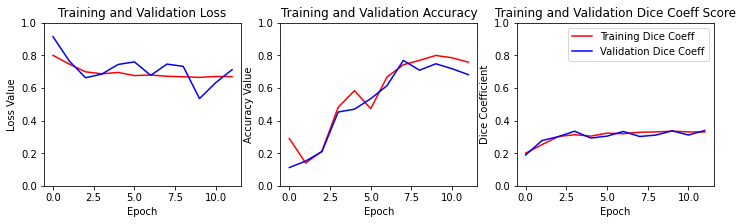

In [ ]:
import matplotlib.pyplot as plt

if(history_scratch is not None):
    # Loss equals 1 - Dice_coeff
    loss = history_scratch.history['loss']
    loss_val = history_scratch.history['val_loss']
    # Accuracy is the build in accuracy metric
    acc = history_scratch.history['accuracy']
    acc_val = history_scratch.history['val_accuracy']
    # Dice coeff is added to our metrics
    dice = history_scratch.history['dice_coef']
    dice_val = history_scratch.history['val_dice_coef']

    epochs = np.arange(len(history_scratch.history['loss'])) # This will give the number of itterations that are done during training.

    plt.figure(figsize=(12, 3))
    plt.subplot(131)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.subplot(132)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Value')
    plt.ylim([0, 1])
    plt.subplot(133)
    plt.plot(epochs, dice, 'r', label='Training Dice Coeff')
    plt.plot(epochs, dice_val, 'b', label='Validation Dice Coeff')
    plt.title('Training and Validation Dice Coeff Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

#### Show predictions

---

Let's predict on our test set and plot results.

In [ ]:
test_datagen_images = ImageDataGenerator(rescale=1./255)
test_datagen_masks = ImageDataGenerator(rescale=1./255)

# Create generator for testing as well
test_image_generator = test_datagen_images.flow_from_dataframe(
    dataframe=valid_data_seg,
    directory=img_dir,
    x_col="img_name",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    target_size=RESIZE_INPUT,
    class_mode=None
)

test_mask_generator = test_datagen_masks.flow_from_dataframe(
    dataframe=valid_data_seg,
    directory=seg_dir,
    x_col="seg_name",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    target_size=RESIZE_INPUT,
    class_mode=None
)

test_generator = (pair for pair in zip(test_image_generator, test_mask_generator))

NO_OF_TEST_IMAGES = len(test_seg_img)
results_scratch = model_scratch.predict(test_generator,steps = (NO_OF_TEST_IMAGES//BATCH_SIZE), verbose=1)

Found 423 validated image filenames.
Found 423 validated image filenames.
52/52 [==============================] - 23s 447ms/step


Looking at the predictions, we can see differences between the good (e.g. 2, 6) and bad results (e.g. 4, 9). Some reasons for this can be the contrast between the object and the background. In case of the good images, the object an be easily distinguished from the background. In case of image 6 (the bird), this is really clear. The prediction really shows the counters of the bird (a bit bigger). Looking at the bad results, take image 7 as example, the bench can't be distinguished that good from the carpet under it. This results in a prediction that does take the bench and carpet as one. 

Longer learning maybe result in better results. Further investigations should be necessary to be sure of this.

Image number  1 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


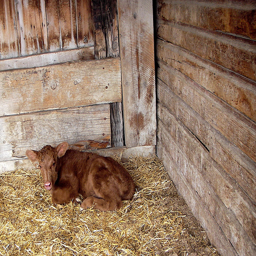

Target Mask:  --------------------


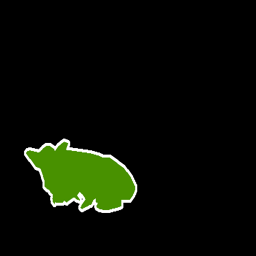

Predicted Mask:  --------------------


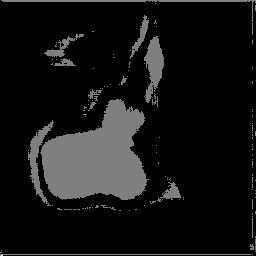

Image number  2 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


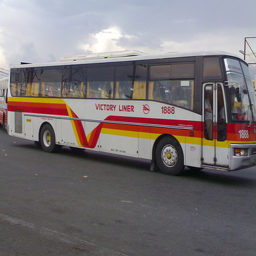

Target Mask:  --------------------


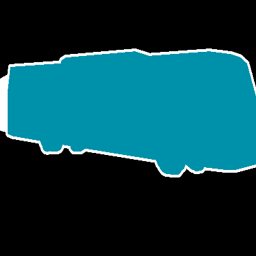

Predicted Mask:  --------------------


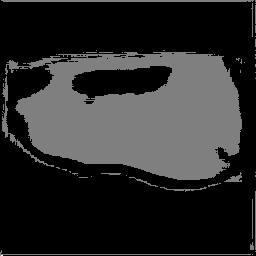

Image number  3 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


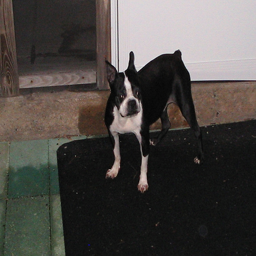

Target Mask:  --------------------


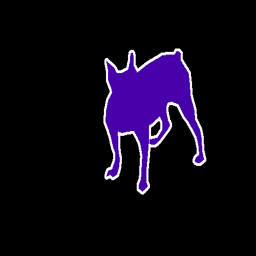

Predicted Mask:  --------------------


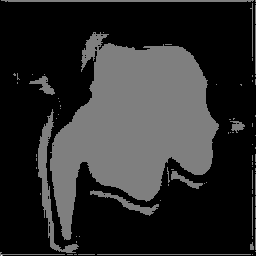

Image number  4 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


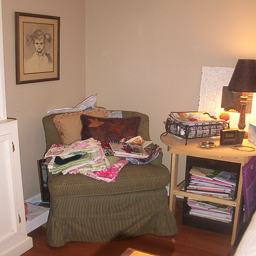

Target Mask:  --------------------


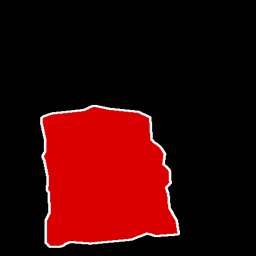

Predicted Mask:  --------------------


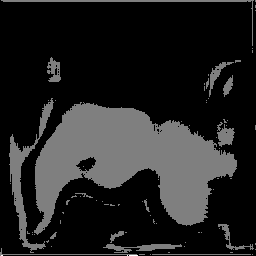

Image number  5 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


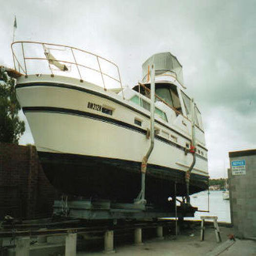

Target Mask:  --------------------


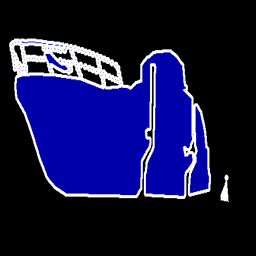

Predicted Mask:  --------------------


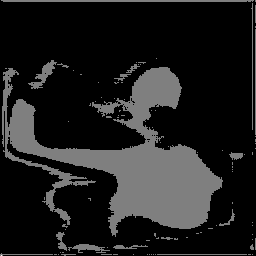

Image number  6 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


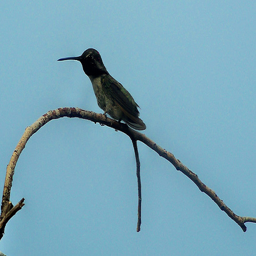

Target Mask:  --------------------


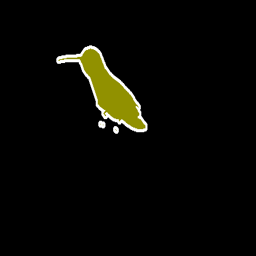

Predicted Mask:  --------------------


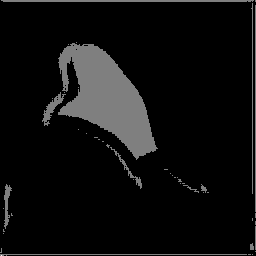

Image number  7 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


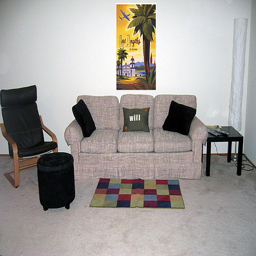

Target Mask:  --------------------


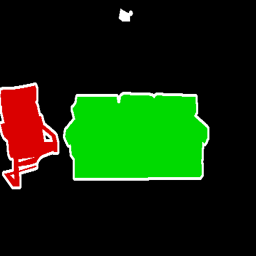

Predicted Mask:  --------------------


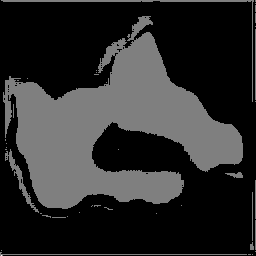

Image number  8 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


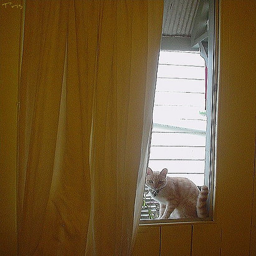

Target Mask:  --------------------


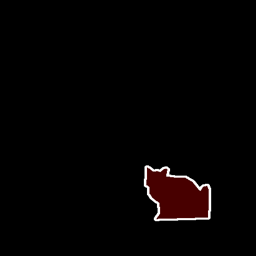

Predicted Mask:  --------------------


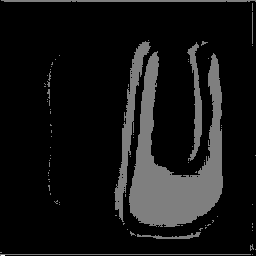

Image number  9 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


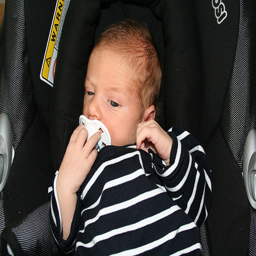

Target Mask:  --------------------


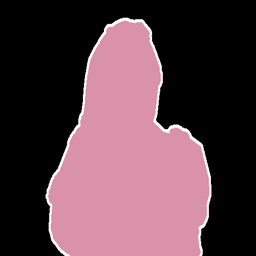

Predicted Mask:  --------------------


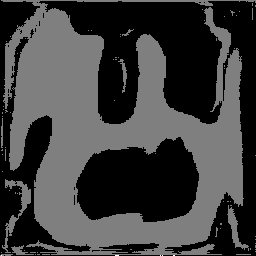

In [ ]:
# Generate predictions for all images in the test set
input_img_paths = sorted([os.path.join(img_dir, fname) for fname in test_seg_img if fname.endswith(".jpg")])
target_img_paths = sorted([os.path.join(seg_dir, fname) for fname in test_seg_mask if fname.endswith(".png") and not fname.startswith(".")])

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(results_scratch[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


for i in range(1, 10):
  print("Image number ", i, "= = = "*50)
  # Display input image
  img = PIL.ImageOps.autocontrast(load_img(input_img_paths[i]))
  print("Original Image: ", "-"*20)
  display(img.resize((256, 256)))

  # Display ground-truth target mask
  img = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
  print("Target Mask: ", "-"*20)
  display(img.resize((256, 256)))

  # Display mask predicted by our model
  print("Predicted Mask: ", "-"*20)
  display_mask(i)  # Note that the model only sees inputs at 150x150.

### Transfer learning

#### Get pre-trained model (encoder, VGG16)

---

As we've said before, first of all, we should get our model. Because we want to do transfer learning, we want to access the knowledge from the network. Hence, we don't want to override the layers (i.e. what it already learned)

In [ ]:
from keras.applications.vgg16 import VGG16 as VGG16
vgg16_encoder = VGG16(
    input_shape=INPUT_SIZE, 
    include_top = False, 
    weights='imagenet')
# Be sure that it can't be trained! 
vgg16_encoder.trainable = False
vgg16_encoder.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

#### Extend model (decoder, Unet)

---

The decoder will be borrowed from our Unet model implemented from scratch in previous section. However, as we look into our implementation from scratch, we see that there are skip connections. In order to add these skip connections to our transfer learning model, we should get access to our layers from the VGG16 model and use these outputs as inputs for our skip connections. To do this, we use the $layers[index].output$ attribute. This will give us the output from a certain layer from our VGG16 network. Because the VGG16 doesn't have dropout layers, we should add these as well. These layers are usefull to prevent overfitting. We copied the dropout layers from our model from scratch. Hence, only at conv1 we use the dropout layer.

Looking at the summary of the VGG16 model, we can see that the parameters comming from the VGG16 model are not able to be trained (summary above). The same parameters can't be trained in our transfer learning model (summary below).

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Conv2D, MaxPooling2D, BatchNormalization, Layer, Dropout
from keras import optimizers, backend

# Here we implent our new segmentation network. VGG16 doesn't have a dropout layer as the original Unet model, that is why a dropout layer is added and used in our new model. 
# We need this skip connections cause we want our data learned in downsampling to be used when we're doing upsampling. This gives extra information to our pixels.
up1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(vgg16_encoder.output))
drop1 = Dropout(0.5)(vgg16_encoder.layers[17].output)
merge1 = concatenate([drop1,up1], axis = 3)
conv1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
conv1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

up2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv1))
#drop2 = Dropout(0.5)(vgg16_encoder.layers[13].output)
merge2 = concatenate([vgg16_encoder.layers[13].output,up2], axis = 3)
conv2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge2)
conv2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)

up3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
#drop3 = Dropout(0.5)(vgg16_encoder.layers[9].output)
merge3 = concatenate([vgg16_encoder.layers[9].output,up3], axis = 3)
conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

up4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv3))
#drop4 = Dropout(0.5)(vgg16_encoder.layers[5].output)
merge4 = concatenate([vgg16_encoder.layers[5].output,up4], axis = 3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

up5 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv4))
#drop5 = Dropout(0.5)(vgg16_encoder.layers[2].output)
merge5 = concatenate([vgg16_encoder.layers[2].output,up5], axis = 3)
conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

conv5 = Conv2D(20, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
# Masks are RGB values, this means that we should be sure that the Unet model van handle RGB values.
conv6 = Conv2D(3, 1, activation = 'sigmoid')(conv5)

model_transfer = Model(input = vgg16_encoder.input, output = conv6)

model_transfer.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef, "accuracy"])

model_transfer.name = "transfer_learning_seg"
model_transfer.summary()

Model: "transfer_learning_seg"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


#### Build data generator 

---

In [ ]:
train_datagen_images_tl = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_datagen_masks_tl = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Creat training images and masks
RESIZE_INPUT = (256, 256)

train_image_generator_tl = train_datagen_images_tl.flow_from_dataframe(
    dataframe=train_data_seg,
    directory=img_dir,
    x_col="img_name",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=RESIZE_INPUT,
    class_mode=None)

train_mask_generator_tl = train_datagen_masks_tl.flow_from_dataframe(
    dataframe=train_data_seg,
    directory=seg_dir,
    x_col="seg_name",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=RESIZE_INPUT,
    class_mode=None)

# Creat training images and masks

validate_image_generator_tl = train_datagen_images_tl.flow_from_dataframe(
    dataframe=train_data_seg,
    directory=img_dir,
    x_col="img_name",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=RESIZE_INPUT,
    class_mode=None)
validate_mask_generator_tl = train_datagen_masks_tl.flow_from_dataframe(
    dataframe=train_data_seg,
    directory=seg_dir,
    x_col="seg_name",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=RESIZE_INPUT,
    class_mode=None)

train_generator_tl = (pair for pair in zip(train_image_generator_tl, train_mask_generator_tl))
validation_generator_tl = (pair for pair in zip(validate_image_generator, validate_mask_generator))

Found 349 validated image filenames.
Found 349 validated image filenames.
Found 87 validated image filenames.
Found 87 validated image filenames.


#### Train model

---

Now we an train the model and use the same kind of generators as in the model from scratch part. In order to be able to adjust setting appart from eachother, we declared the generators also here and renamed them. 

In [ ]:
model_transfer_file =  '/content/model_transfer_seg.h5'
weights_path_tf = 'weights_vgg_unet'

checkpoint = ModelCheckpoint(weights_path_tf, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger('./log.out', append=True, separator=';')
earlystopping = EarlyStopping(monitor = 'val_dice_coef', verbose = 1, min_delta = 0.01, patience = 8, mode='max')
# Callbacks list is used to check during training different parameters. For example, earlystopping will stop the training process when, after 8 itterations, the val_dice_coef is still not imporved.
callbacks_list = [checkpoint, csv_logger, earlystopping]

history_seg = None
if not os.path.isfile(model_transfer_file):
    history_seg = model_transfer.fit(train_generator_tl, 
                      epochs=NO_OF_EPOCHS, 
                      steps_per_epoch = (NO_OF_TRAINING_IMAGES*0.77//BATCH_SIZE), 
                      callbacks=callbacks_list,
                      validation_data = (item for item in validation_generator_tl), 
                      validation_steps = (NO_OF_TRAINING_IMAGES*0.23//BATCH_SIZE))
    model_transfer.save(model_transfer_file)
else:
    model_transfer.load_weights(model_transfer_file)

Epoch 1/50
41/41 [==============================] - 46s 1s/step - loss: 0.7521 - dice_coef: 0.2479 - accuracy: 0.5985 - val_loss: 0.6759 - val_dice_coef: 0.2491 - val_accuracy: 0.1997

Epoch 00001: val_dice_coef improved from -inf to 0.24909, saving model to weights_vgg_unet
Epoch 2/50
41/41 [==============================] - 40s 984ms/step - loss: 0.6703 - dice_coef: 0.3297 - accuracy: 0.4046 - val_loss: 0.6160 - val_dice_coef: 0.3685 - val_accuracy: 0.6702

Epoch 00002: val_dice_coef improved from 0.24909 to 0.36851, saving model to weights_vgg_unet
Epoch 3/50
41/41 [==============================] - 37s 894ms/step - loss: 0.6410 - dice_coef: 0.3590 - accuracy: 0.3817 - val_loss: 0.6386 - val_dice_coef: 0.3494 - val_accuracy: 0.7195

Epoch 00003: val_dice_coef did not improve from 0.36851
Epoch 4/50
41/41 [==============================] - 37s 892ms/step - loss: 0.6585 - dice_coef: 0.3415 - accuracy: 0.7233 - val_loss: 0.5840 - val_dice_coef: 0.3550 - val_accuracy: 0.5565

Epoch 0000

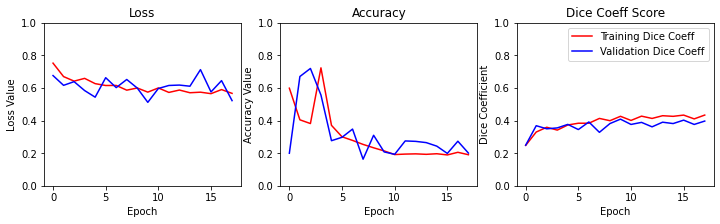

In [ ]:
if history_seg is not None:
    loss = history_seg.history['loss']
    loss_val = history_seg.history['val_loss']
    acc = history_seg.history['accuracy']
    acc_val = history_seg.history['val_accuracy']
    dice = history_seg.history['dice_coef']
    dice_val = history_seg.history['val_dice_coef']

    epochs = np.arange(len(history_seg.history['loss'])) # This will give the number of itterations that are done during training.

    plt.figure(figsize=(12, 3))
    plt.subplot(131)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.subplot(132)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Value')
    plt.ylim([0, 1])
    plt.subplot(133)
    plt.plot(epochs, dice, 'r', label='Training Dice Coeff')
    plt.plot(epochs, dice_val, 'b', label='Validation Dice Coeff')
    plt.title('Dice Coeff Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

#### Predict

---

Now, let's predict and look at actual results. 

In [ ]:
test_datagen_images_seg = ImageDataGenerator(rescale=1./255)
test_datagen_masks_seg = ImageDataGenerator(rescale=1./255)

# Create generator for testing as well
test_image_generator_seg = test_datagen_images_seg.flow_from_dataframe(
    dataframe=valid_data_seg,
    directory=img_dir,
    x_col="img_name",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    target_size=RESIZE_INPUT,
    class_mode=None
)

test_mask_generator_seg = test_datagen_masks_seg.flow_from_dataframe(
    dataframe=valid_data_seg,
    directory=seg_dir,
    x_col="seg_name",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    target_size=RESIZE_INPUT,
    class_mode=None
)

test_generator_seg = (pair for pair in zip(test_image_generator_seg, test_mask_generator_seg))

NO_OF_TEST_IMAGES = len(test_seg_img)
result_seg_path = os.path.join(cv_folder, 'SegResults')
results_transfer = model_transfer.predict(test_generator_seg,steps = (NO_OF_TEST_IMAGES//BATCH_SIZE), verbose=1)

Found 423 validated image filenames.
Found 423 validated image filenames.
52/52 [==============================] - 15s 293ms/step


#### Show predictions

--- 

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


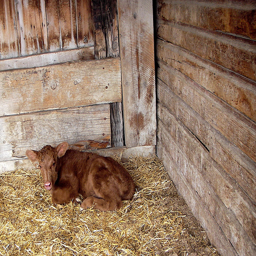

Target Mask:  --------------------


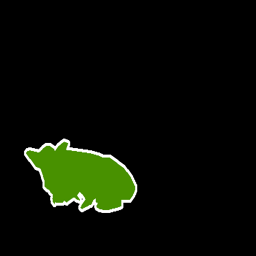

Predicted Mask:  --------------------


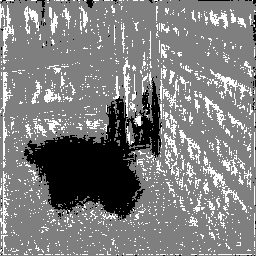

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


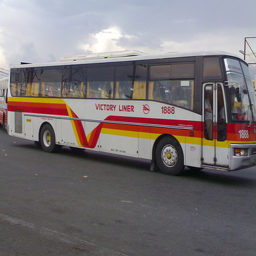

Target Mask:  --------------------


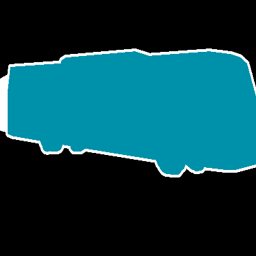

Predicted Mask:  --------------------


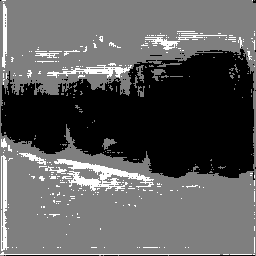

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


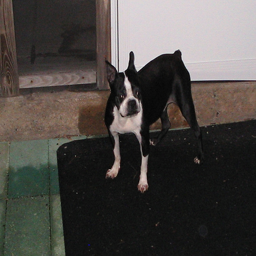

Target Mask:  --------------------


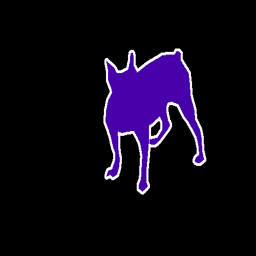

Predicted Mask:  --------------------


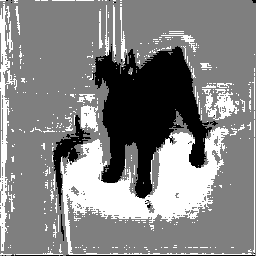

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


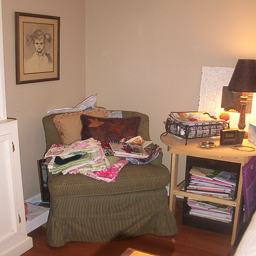

Target Mask:  --------------------


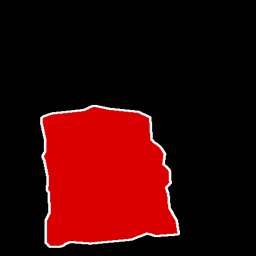

Predicted Mask:  --------------------


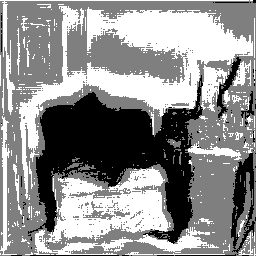

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


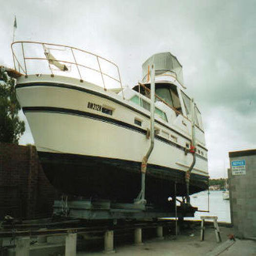

Target Mask:  --------------------


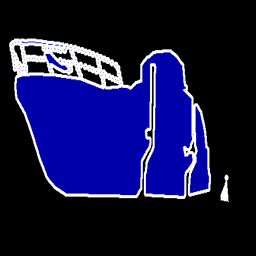

Predicted Mask:  --------------------


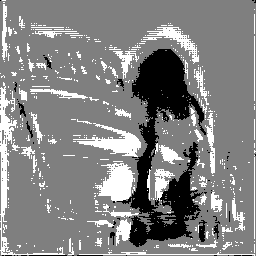

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


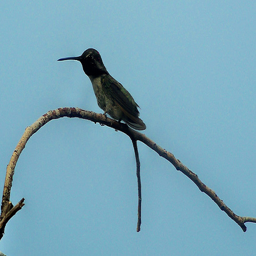

Target Mask:  --------------------


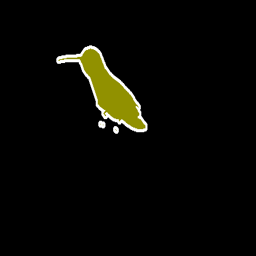

Predicted Mask:  --------------------


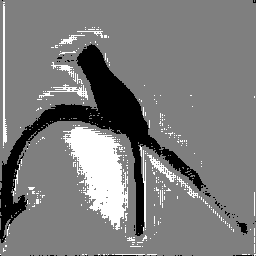

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


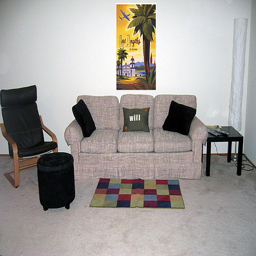

Target Mask:  --------------------


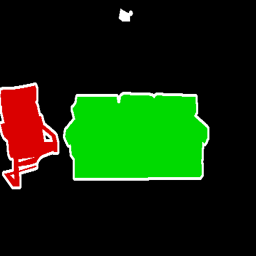

Predicted Mask:  --------------------


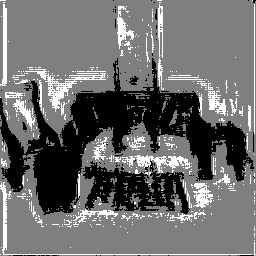

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


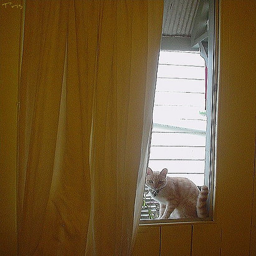

Target Mask:  --------------------


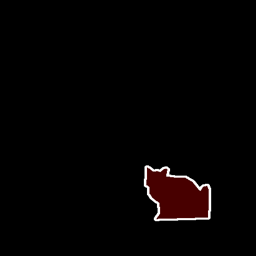

Predicted Mask:  --------------------


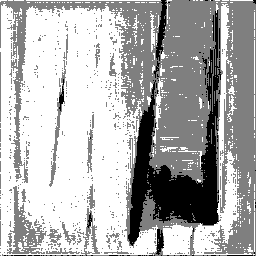

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Original Image:  --------------------


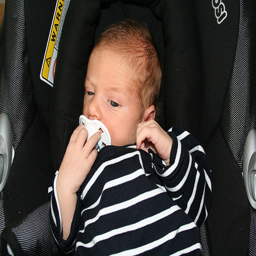

Target Mask:  --------------------


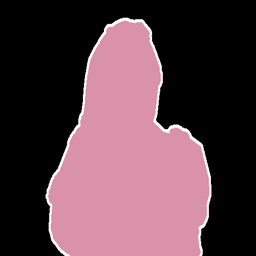

Predicted Mask:  --------------------


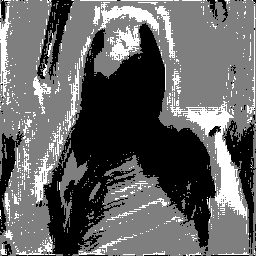

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from tensorflow import keras
from PIL import ImageOps

# Generate predictions for all images in the validation set
input_img_paths = sorted([os.path.join(img_dir, fname) for fname in test_seg_img if fname.endswith(".jpg")])
target_img_paths = sorted([os.path.join(seg_dir, fname) for fname in test_seg_mask if fname.endswith(".png") and not fname.startswith(".")])

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(results_transfer[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


for i in range(1, 10):
  print("= = = "*50)
  # Display input image
  img = PIL.ImageOps.autocontrast(load_img(input_img_paths[i]))
  print("Original Image: ", "-"*20)
  display(img.resize((256, 256)))

  # Display ground-truth target mask
  img = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
  print("Target Mask: ", "-"*20)
  display(img.resize((256, 256)))

  # Display mask predicted by our model
  print("Predicted Mask: ", "-"*20)
  display_mask(i)  # Note that the model only sees inputs at 150x150.

### Conlcusion Semantic Segmentation

---

As we did expect, our model from scratch does predict less accurate than our model where transfer learning is used. Some examples are given below where there is a clear distinction between the prediction of both models. Looking at the fifth image (boat), it's clear that the prediction is better done by the transfer learning model. It did learn the counters and it the shape of the boat can be seen in the mask. The shape of the boat can't be recognized within the prediction of the model from scratch.

However, the results doesn't mean that this is always the case. There can be improvements done concerning the model from scratch. Training epochs where only 11, so probably, taken a less strict early stop parameter, will train the network longer and can result in better segmentation. It is possible that the model did enter a local maximum and need a couple more epochs to overcome this. The difference with the transfer learning model is that the encoder part of the model already does have a lot of information and does know which information is important and which is not. Giving this knowledge to our decoder does result in better predictions with the same strict early stop parameter.

A second thing to improve, both for the transfer learning model and model from scratch, is hyper parameter optimisation. A well known difficulty within machine learning is the one from hyperparameters. The loss function is one of the most used. However, updating internal paramaters in the model is maybe not a good idea based on this loss function. An other thing is to take an other activation function. Now, sigmoid is taken, but further invesitgation will clearify whether are not, this is the best approach to follow. 

In [ ]:
def display_mask(i, predict_array):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(predict_array[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


for i in range(1, 10):
  print("Image ", i, " = = = "*50)
  # Display input image
  img = PIL.ImageOps.autocontrast(load_img(input_img_paths[i]))
  print("Original Image: ", "-"*20)
  display(img.resize((256, 256)))

  # Display mask predicted by our model
  print("Predicted Mask from SCRATCH MODEL: ", "-"*20)
  display_mask(i, results_scratch)  # Note that the model only sees inputs at 150x150.

  # Display mask predicted by our model
  print("Predicted Mask from TF MODEL: ", "-"*20)
  display_mask(i, results_transfer)  # Note that the model only sees inputs at 150x150.

## Task 3: Adversarial attack



In order to give some thoughts about what should be done and show that we thought about this subject, we will discuss shortly which approach we would have taken to implement this. 

#### Description

To implement an Adversarial network an extra layer should be added to the model. It can be seen as some kind of preproccessing where the image is converted to a representation that fools the system. This representation are known to fool classification algorithms, hence we are sure that the attack is able to work. However, because we don't have the implementation, we are not sure that it will fool our system or not. 

The setup of this is attack can be used in a real world scenario, however, a stupid one. When a developer of this model would let you reach the model's layers, add another layer, and train the model again such, this would be a really security issue. So, the way we would implement it, shouldn't be the one that is considered as an attack. However, there is knoweldge of pictures such that classifiers are not able to recognize this image, so we also think that it is able to change the pictures in such a way that the classifier is fooled without any interference with the original model. 

To prevent these attacks, the first thing to do is to be sure the security around your model is really good. No access should be allowed to the model itself. In order to improve the robustness, multiple classifiers can be work toghether to get a global score. When we train classifiers on different kind of images, where one classifier will be trained on adversarial examples of the orginal images, then wa should be able to detect inference from outside. Training a network that will classify, with 100% confidence, always the right output, is nill. Using multiple classifiers will also be harder to fool because we can filter away uncertain predictions by a classifier and dig deeper in why it did classify this wrong. This will lead into a preventation with human inference, rather than getting a robust model. But, the models combined is a robust model. 

There also exists attacks called black-box attack, which consist in attacking a classifier for which we do not have access to the code. One way of doing it is by adding an adversarial noise to the input image and fool the classifier. However this kink of attack is much simpler to prevent since the attack may not target the good weakness of the classifier. In order to prevent these attack, some pre-processing could blur the input image to remove the adversarial added to the image.


## 3. Discussion

This notebook shows the implementation of two classification networks and two segmentation networks for the image dataset VOC2009. For both classification and segmentation, one network was built from scratch, and one network used transfer learning to perform a better efficiency.

The dataset of image VOC2009 is relatively small and contains approximately 7000 images (3500 training, 3500 validation). Testing image for this dataset can be downloaded separately. In this project, the performances of the networks are assessed using the validation set as it was mentionned on Toledo. 

### Classification

---

Classification of images consits in assigning one or multiple class label to an image. VOC2009 dataset contains images which can be assigned to multiple label. However, it was decided that our classification algorithm would only have to find one of the corrects labels from the image.

A CNN is made of a set of convolutional and max pooling layers. The convolutions increase the dimentionality of the image by creating filters for a specific features of the image. For example, one of the filter that help recognising a car could looks like a tire. Max pooling layers reduce the dimentionality by getting the maximum value of the previous convolutional filter in a small area (pool size). The last layer of the CNN consist in a set of fully connected layers for classification. These fully connected layers takes as input all the features computed from the previous layers and output a vector in one hot encoding associated to the class of the input image.

Pixels in an image have a high probability to be linked to their neighborhood. CNNs take advantage of local connectivity to classify images. This local connectivity allows the use of deeper networks since the number of parameters to be learned is much smaller. 

Features that are isolated inside a CNN are not especially human readable features. It could correspond to anything that appears in the image. For example, we, as human, would describe a cat as a four-legs animal with a long tail. And features inside a CNN would describe a cat as an animal with clenched hair.

--

Learning a model from scratch appears to be very difficult. We think that the lack of efficiency of the model from scratch comes from the size of the train set. 3500 images is a low number of images to train a CNN. Out network has more than 100.000 weights and was not able to correctly generalize the data.

--

Learning a model using transfer learning lead to better results. The network that was implemented uses resnet50 trained on the imagenet dataset. According to keras documentation, this networks has 0.749 of top 1 accuracy and 0.921 of top 5 accuracy. It was designed to classify images from 1000 classes. 

As VOC2009 dataset contains only 20 classes, a new top layer was built to classify the output of the resnet50 network. At first, we tried to train all the weights of the network at once. It was expected that the architecture of resnet50 in addition to the pre-trained weights would lead to very efficient results. However, it only breaked the resnet50 networks by changing all the weights. Therefore, it was chosen to train the network by freezing all the weights from resnet50 (i.e. only training the new fully connected layer). This led to much better results and reduced risks of overfitting since the number of parameters to be learned was smaller.

### Segmentation

--- 

Doing semantic segmentation on images can be seen as solving a classification problem on the level of pixels instead of the whole image. This means that segmentation will classify every pixel to a category and use these classifications as masks to show where the model thinks the object is within the image.

The theory behind this idea is quite simple. However, in practical, a lot of things are going on. Compared to classification, a lot more knoweledge about the images is nessecary to come up with some decend segmentation model.

A segmentation model can be splitted in two parts, the encoder and decoder. The encoder will be almoste the same as a classification algorithm. The difference here is that the encoder of a segmentation model doesn't have this fully connected layers. Instead, it does have a decoder part. The decoder will build the image back up, but while doing this, it get's extra information from the different convolution blocks in the encoder. This information will give information on a pixel level and can be used to label the different pixels. The output of a segmenetation model is a matrix where every cell represent a pixel with a value in every cel representing the class to which it belongs. 

--

The segmentation part did work better than expected, concedering the time and previous knowledge/experience about/with these kind of networks. The model from scratch was a good way to start and get some insights in how the model does behave and what the different parameters are. Once we where familiarised with these parameters, the segmentation via transfer learning was pretty straight forward. We did already know what the goal of transfer learning is, so the only hard part was to come up with a clever idea in order to get access to the layers, without training the layers, from the pre-trained network. If we couldn't access this information, the segmentation shouldn't be working as well. The segmentation from scratch can still be improved in a couple of ways. Further investigation of skip connections can be done. Better training based on one hot encoded data, rather than only a mask as image, etc. For now, the results does show what the network should do and it let is think, analyse and debug a lot while implementing. Hence, for the objective of the course, we can conclude that the results are decent. 

--

The segmenetation from scratch is not good enough to be placed in a real world problem, nor is the model via transfer learning. But, the model via transfer learning does come closer to what we expect a segmentation should do than our model from scratch. The problem is that the it only achieve 50% accuracy when we look at the Dice Coeff score. This can also be seen in the results. The counters can be seen, but there are also object within the mask that shouldn't be classified as the object itself. 

--

If we have more time, decent research should be done in order to compare different models and summarize their strengths and weaknesses. We do have the idea that a model is really dataset specific. Giving it an order dataset results in poor results. Doing this research, more information about good practices concerning skip connections, maxpooling, etc. should be gathered. A few of them are implemented, but we are sure that there is more going on than what we did implement (the results does show that as well). So beside getting more knowledge about good practices and good networks, something that should also be done is getting more understanding about the maths behind the network. Why does a layer respond differently on some kernel size, activation function, etc. is something that should be made aware of when building stable models to do segmentation. 